# XGBoost

**Import train, val, test sets from Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/Colab Notebooks/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import polars as pl
from datetime import timedelta
import os

In [3]:
df_train = pl.read_parquet(os.path.join(drive_path, "df_train.parquet"))
df_val = pl.read_parquet(os.path.join(drive_path, "df_val.parquet"))
df_test = pl.read_parquet(os.path.join(drive_path, "df_test.parquet"))

In [4]:
# Combine df_train and df_val for final model training
df_train = df_train.vstack(df_val)

In [5]:
df_test.height

1030388

**Training**

In [6]:
pip install xgboost==1.7.6

In [7]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, precision_recall_curve
import pandas as pd

In [8]:
opt_features = ["Amount", "year", "day_of_month", "day_of_week", "hour", "minute", "second",
            "currency_mismatch", "high_risk_sender", "high_risk_receiver",
            "fanin_30d", "fanin_intensity_ratio",
            "sent_to_received_ratio_monthly", "back_and_forth_transfers",
            "circular_transaction_count", "Is_laundering"]

In [9]:
# Configuration
features = opt_features[:-1]
target = opt_features[-1]
early_stopping_rounds = 50
num_boost_round = 500
verbose_eval = False        # set to integer for logging every k rounds

In [10]:
# 1) Convert Polars -> NumPy once (casting to float32)
#    Handle missing values and simple categorical encoding if needed.
def polars_to_numpy_for_xgb(df_pl: pl.DataFrame, features, target):
    # Ensure numeric features; cast numeric-like to Float32
    X_df = df_pl.select([pl.col(c).cast(pl.Float32).alias(c) for c in features])
    y_arr = df_pl.select(pl.col(target)).to_numpy().ravel()
    X_arr = X_df.to_numpy()
    return X_arr, y_arr

X_train, y_train = polars_to_numpy_for_xgb(df_train, features, target)
X_test, y_test = polars_to_numpy_for_xgb(df_test, features, target)

In [11]:
# 2) Build DMatrix once per dataset (faster than rebuilding inside loop)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)
watchlist = [(dtrain, "train"), (dtest, "eval")]

In [12]:
params = {
        "max_depth": 10, #3,
        "eta": 0.01, #0.1,                 # alias for learning_rate in xgb.train params
        "subsample": 1,             #0.3,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "seed": 42,
        "verbosity": 0,
        "nthread": -1
    }

In [13]:
final_model = xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=verbose_eval
    )

In [15]:
final_model.save_model(f'{drive_path}/final_model.xgb')

In [16]:
preds_proba = final_model.predict(dtest)
preds = (preds_proba > 0.5).astype(int)

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score, average_precision_score

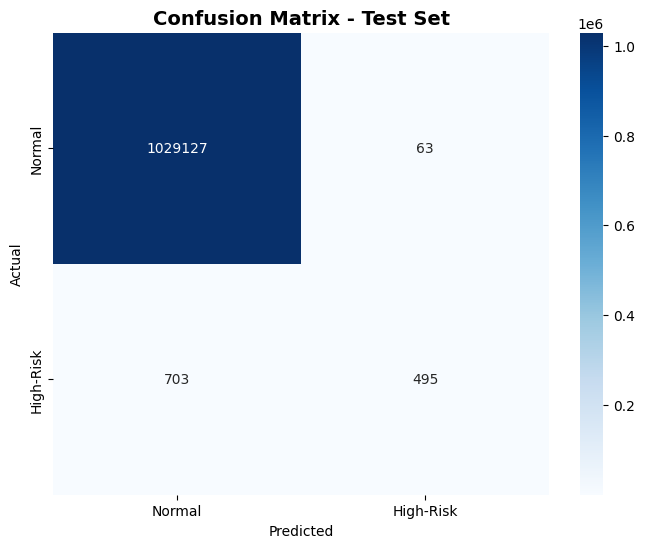

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'High-Risk'],
            yticklabels=['Normal', 'High-Risk'])
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

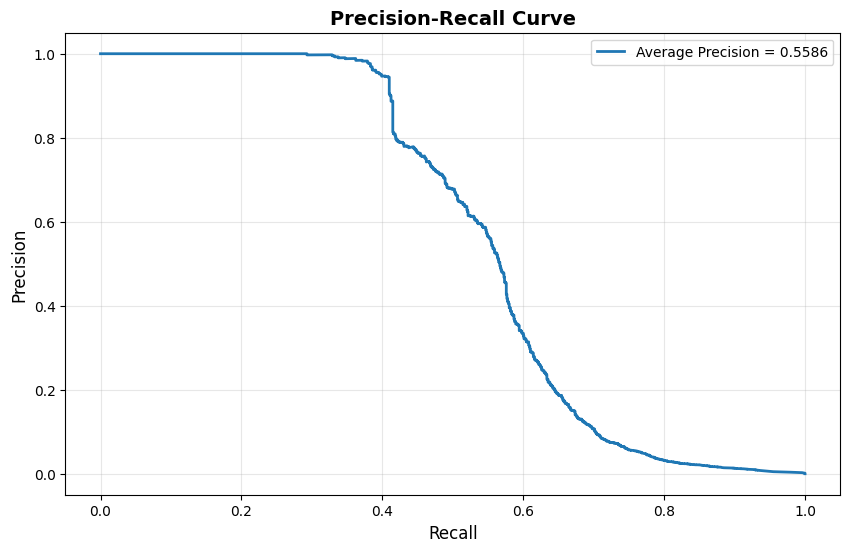

In [19]:
# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, preds_proba)
test_auc = auc(recall, precision)
avg_prec = average_precision_score(y_test, preds_proba)


plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2, label=f'Average Precision = {avg_prec:.4f}')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [20]:
recall, precision, thresholds_pr

(array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        6.67779633e-03, 8.34724541e-04, 0.00000000e+00]),
 array([0.00116267, 0.00220378, 0.00220382, ..., 1.        , 1.        ,
        1.        ]),
 array([0.00335769, 0.00335774, 0.0033578 , ..., 0.9961842 , 0.9962883 ,
        0.9971517 ], dtype=float32))

In [21]:
import numpy as np
# Save list and NumPy arrays using pickle
with open(os.path.join(drive_path, "XGBoost_recall.npy"), "wb") as f:
    np.save(f, recall)

with open(os.path.join(drive_path, "XGBoost_precision.npy"), "wb") as f:
    np.save(f, precision)

with open(os.path.join(drive_path, "XGBoost_thresholds.npy"), "wb") as f:
    np.save(f, thresholds_pr)

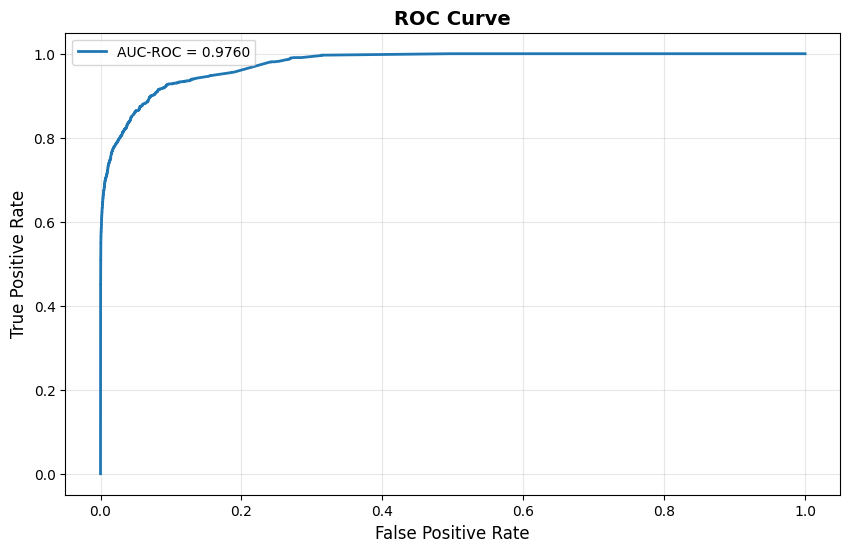

In [22]:
# True Positve Rate - False Positive Rate
fpr, tpr, thresholds = roc_curve(y_test, preds_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'AUC-ROC = {roc_auc:.4f}')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [24]:
report_dict = classification_report(y_test, preds, output_dict=True)
report_df = pd.DataFrame(report_dict)
report_df

,0,1,accuracy,macro avg,weighted avg
precision,9.993174e-01,0.887097,0.999257,9.432071e-01,9.991869e-01
recall,9.999388e-01,0.413189,0.999257,7.065637e-01,9.992566e-01
f1-score,9.996280e-01,0.563781,0.999257,7.817046e-01,9.991212e-01
support,1.029190e+06,1198.000000,0.999257,1.030388e+06,1.030388e+06


**Save precision-recall-threshold for PRC curve**

In [26]:
with open(os.path.join(drive_path, "precision.npy"), "wb") as f:
    np.save(f, precision)

with open(os.path.join(drive_path, "recall.npy"), "wb") as f:
    np.save(f, recall)

with open(os.path.join(drive_path, "thresholds_pr.npy"), "wb") as f:
    np.save(f, thresholds_pr)